In [56]:
from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import os
import copy
from matplotlib import pyplot as plt

Load real data and construct tensor for dPCA

In [223]:
# NY125, 2019-09-17
# animal = 'NY125'
# date = '2019-09-17'

# animal = 'NY123'
# date = '2019-09-18'

animal = 'NY126'
date = '2019-09-17'

file = 'dec_proj_force_bin.pkl'

data_home = r'Z:\Ines\Data_analysis\Pickles'
data_dir = os.path.join(data_home, animal, date, 'vivek')
data_path = os.path.join(data_dir, file)
print(os.path.exists(data_path))

ld = np.load(data_path, allow_pickle=True)

True


In [224]:
ld.keys()

dict_keys(['d_dec', 'dec_dim_list', 'cond_list', 'f_match_flag', 'r_match', 'nf_cond_sel', 'dim_df', 'nf_df', 'bin_dic', 'fbin_dic', 'stat_n_fbin'])

In [225]:
ld['d_dec'].keys()

dict_keys(['dec_dic', 'dec_list', 'dec_dim', 'angle_dic', 'num_folds', 'num_neurons', 'action_list', 'shuffle_list', 'cond_list', 'action2pretty', 'ld'])

In [226]:
num_neurons = ld['d_dec']['num_neurons']

action_list = ld['cond_list']
num_actions = len(action_list)

force_bins = np.arange(ld['bin_dic']['num_bins'])
num_force_bins = ld['bin_dic']['num_bins']
f_label = ['3-4g', '4-5g', '5-6g', '6-7g', '>7g']

In [227]:
#append force bins into dataframe: 
f_vec = np.concatenate((ld['fbin_dic']['B'], ld['fbin_dic']['A']))
# print(f_vec.shape)
nf_df = copy.copy(ld['nf_df'])
nf_df['force_bin'] = f_vec

In [228]:
# ld['bin_dic']

<IPython.core.display.Javascript object>


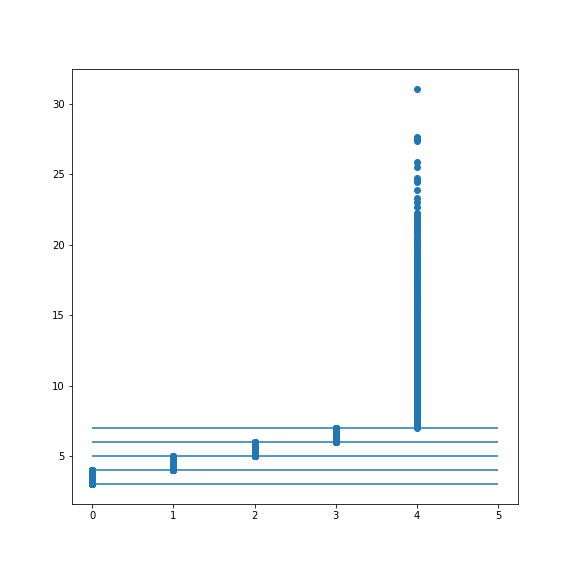

In [229]:
plt.figure(figsize=(8,8))
plt.scatter(nf_df['force_bin'], nf_df['force'])
plt.hlines(ld['bin_dic']['vec'][:-1], 0, ld['bin_dic']['num_bins'])

In [230]:
force_bins

array([0, 1, 2, 3, 4])

In [231]:
nf_df.head()

,force,action,0,1,2,3,4,5,6,7,...,116,117,118,119,120,121,122,123,124,force_bin
0,3.195529,B,-0.211756,-0.379540,-0.020621,0.634434,-0.751322,-0.255618,-0.443199,-0.708168,...,1.030625,0.624706,0.998281,0.640687,0.223856,0.712597,-0.847543,2.610704,-2.492328,0
1,4.092661,B,0.582184,0.406331,0.319430,0.481111,0.574279,-0.154617,0.051847,-0.237525,...,-0.030088,1.797435,0.982035,1.929124,1.428285,0.296690,0.292220,0.311033,1.584224,1
2,6.621167,B,0.380080,0.280898,0.458432,0.610129,7.844183,-0.201165,1.033521,0.239587,...,1.069376,2.050364,1.364051,1.542188,0.815335,1.087090,0.754730,1.759019,0.909884,3
3,4.166727,B,-0.378089,-0.069629,0.596439,-0.086456,2.196541,-0.018626,0.551091,0.705384,...,0.334106,2.116447,1.717374,0.141136,-0.092069,0.501883,-0.010013,-0.149703,0.760591,1
4,3.522375,B,0.586167,0.690522,-0.571288,-0.301244,0.261298,0.024945,0.051489,0.159530,...,0.566835,0.290336,-0.116292,0.337913,-0.349247,0.854793,1.426132,0.187215,-0.607837,0


In [232]:
#identify number of trials for each (action, force_bin)
num_trials_mat = np.zeros((num_actions, num_force_bins))
for i_a,a in enumerate(action_list):
    num_trials_dic[i_a, 'vec'] = []
    for f in force_bins:
        #print(i_a, i_f)
        sel_a = (nf_df['action']==a)
        sel_f = (nf_df['force_bin']==f)
        sel = sel_a&sel_f
        num = np.sum(sel)
        num_trials_mat[i_a, f] = num
num_trials_mat = num_trials_mat.astype(int)
max_num_trials = np.max(num_trials_mat)

print(num_trials_mat)
print(max_num_trials)

[[653 199 131  93 322]
 [ 85  51  36  33 242]]
653


<IPython.core.display.Javascript object>


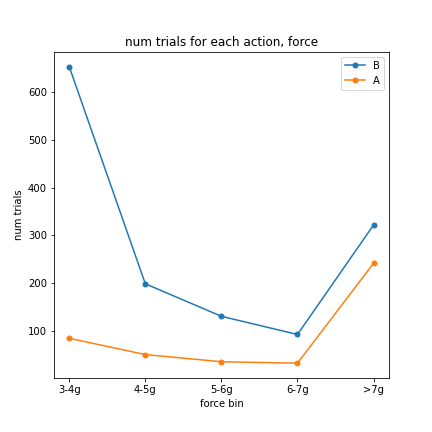

In [235]:
#Inspect how many trials:
plt.figure(figsize=(6,6))
for i_a,a in enumerate(action_list):
    plt.plot(num_trials_mat[i_a,:], '.-', label=a, markersize=10)
plt.xticks(force_bins, f_label)
plt.xlabel('force bin')
plt.ylabel('num trials')
plt.title('num trials for each action, force')
plt.legend()

In [236]:
force_bins

array([0, 1, 2, 3, 4])

In [237]:
force_bins[0]

0

In [238]:
#construct trialR
#shape: #trials X neurons X actions X forces
trialR = np.ones((max_num_trials, num_neurons, num_actions, num_force_bins))*np.nan

for i_a, a in enumerate(action_list):
    for f in force_bins:
        num_trials = num_trials_mat[i_a, f]
        
        sel_a = (nf_df['action']==a)
        sel_f = (nf_df['force_bin']==f)
        sel = sel_a&sel_f
        
        for i_n in range(num_neurons):
            trialR[:num_trials, i_n, i_a, f] = nf_df[i_n][sel]
        

In [239]:
#inspect:
trialR[:,0,1,0]

array([ 5.84984691e-01,  1.96546264e+00,  3.36598602e-01, -8.50475879e-01,
       -4.74766889e-01, -1.18386255e-01, -1.93467651e-01,  5.34202823e-01,
       -2.29405549e-01,  3.06123251e-01, -5.17790914e-01, -2.00903296e-01,
       -9.31676670e-01, -1.66294797e-03,  5.05350952e-01, -1.00571654e-01,
        5.20246500e-01,  3.14260154e-01, -3.84636847e-01, -8.98075249e-01,
       -1.10276425e+00,  2.47019017e-01,  1.16084932e-01,  1.77532334e-01,
       -2.03424017e-01,  5.00081038e-01,  8.99867200e-03,  6.87046551e-01,
       -5.93611503e-01,  5.56327078e-01, -2.18868728e-01,  1.37418579e-02,
       -1.09837910e+00, -6.70532356e-01,  2.97844156e-01,  9.05166848e-01,
       -8.83018161e-01, -1.07172700e-01,  1.36076221e-01,  3.29612260e-02,
       -1.23581374e-02, -8.49161131e-01,  2.88529954e-01, -1.30117389e-01,
        3.25730045e-01,  7.22017249e-01,  1.51490738e+00,  1.86139878e-01,
       -2.66864906e-01,  4.46816323e-01,  1.03433099e+00, -5.48800688e-01,
       -1.24032634e+00,  

In [240]:
#trial-average data
R = np.nanmean(trialR, 0)
R_c = copy.deepcopy(R)

# center data
R_c -= np.nanmean(R_c.reshape((num_neurons,-1)),1)[:,None,None]

<IPython.core.display.Javascript object>


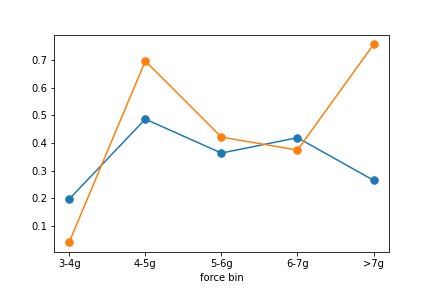

Text(0.5, 0, 'force bin')

In [252]:
#Inspect average activity of individual neurons: 

i_n = 0
plt.figure()
for i_a in range(num_actions):
    plt.plot(R[i_n,i_a,:], '.-', markersize=15, label=action_list[i_a])
plt.xticks(force_bins, f_label)
plt.xlabel('force bin')

In [242]:
max_num_trials

653

In [243]:
trialR.shape #trials X neurons X num_actions X num_force

(653, 125, 2, 5)

In [244]:
R.shape #neurons X num_actions X num_force

(125, 2, 5)

In [245]:
del dpca

In [246]:
dpca = dPCA.dPCA(labels='af',regularizer='auto')
dpca.protect = []

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


Now fit the data (R) using the model we just instatiated. Note that we only need trial-to-trial data when we want to optimize over the regularization parameter.

In [247]:
Z = dpca.fit_transform(R,trialR)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.03571620900974838
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [248]:
Z.keys()

dict_keys(['a', 'f', 'af'])

In [249]:
Z['a'].shape

(10, 2, 5)

In [250]:
Z['f'].shape

(10, 2, 5)

<IPython.core.display.Javascript object>


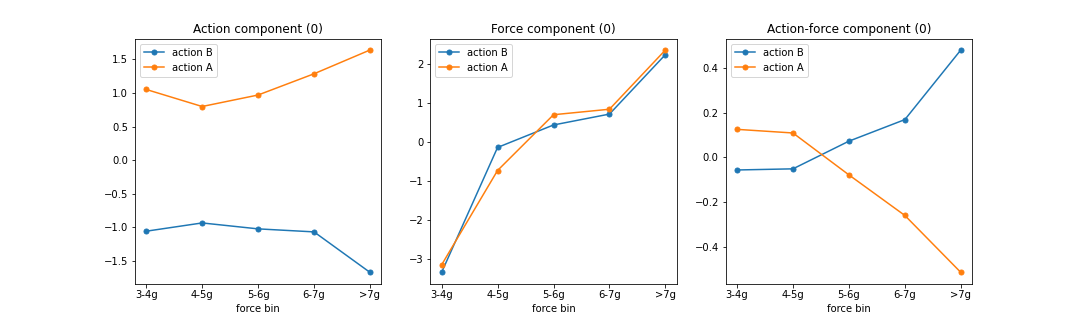

In [251]:
force_array = force_bins 

# figure(figsize=(16,7))
figure(figsize=(15,4.5))

i_comp = 0
subplot(131)

for i_a, a in enumerate(action_list):
    plot(force_array, Z['a'][i_comp,i_a], '.-', markersize=10, label='action '+action_list[i_a])
plt.xticks(force_bins, f_label)
plt.xlabel('force bin')
title('Action component'+' ('+str(i_comp)+')')
legend()
    
subplot(132)

for i_a, a in enumerate(action_list):
    plot(force_array,Z['f'][i_comp,i_a], '.-', markersize=10, label='action '+action_list[i_a])
plt.xticks(force_bins, f_label)
plt.xlabel('force bin')
title('Force component'+' ('+str(i_comp)+')')
legend()
    
subplot(133)

for i_a, a in enumerate(action_list):
    plot(force_array,Z['af'][i_comp,i_a], '.-', markersize=10, label='action '+action_list[i_a])
plt.xticks(force_bins, f_label)
plt.xlabel('force bin')
title('Action-force component'+' ('+str(i_comp)+')')
legend()
show()

In [253]:
ld.keys()

dict_keys(['d_dec', 'dec_dim_list', 'cond_list', 'f_match_flag', 'r_match', 'nf_cond_sel', 'dim_df', 'nf_df', 'bin_dic', 'fbin_dic', 'stat_n_fbin'])

<IPython.core.display.Javascript object>


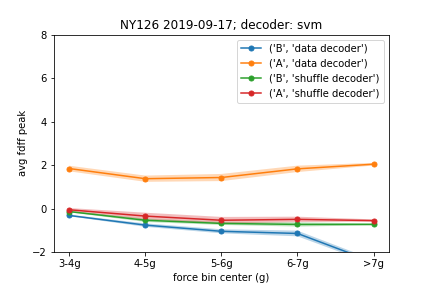

('svm', 'data')
('svm', 'shuffle')


<IPython.core.display.Javascript object>


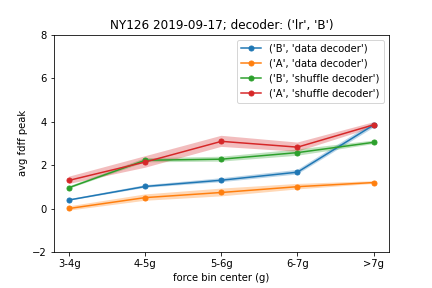

(('lr', 'B'), 'data')
(('lr', 'B'), 'shuffle')


<IPython.core.display.Javascript object>


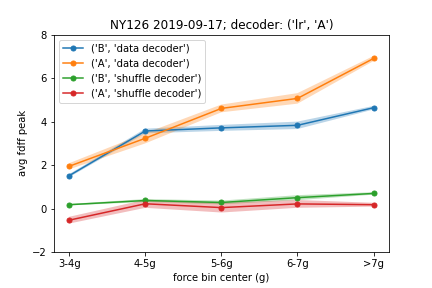

(('lr', 'A'), 'data')
(('lr', 'A'), 'shuffle')


In [254]:
#Compare to projections on decoders we found: 
dec_list = ld['d_dec']['dec_list']
shuffle_list = ld['d_dec']['shuffle_list']
cond_list = ld['cond_list']
stat_n_fbin = ld['stat_n_fbin']
bin_dic = ld['bin_dic']


x = np.arange(bin_dic['num_bins'])
x_label = ['3-4g', '4-5g', '5-6g', '6-7g', '>7g']
    
for dec in dec_list:
    plt.figure()
    for s in shuffle_list:
        var = (dec, s)
        print(var)
    
        for cond in cond_list:
            y = stat_n_fbin[cond, var]['mean']
            sem = stat_n_fbin[cond, var]['sem']

            plt.plot(x, y, '.-', markersize=10, label=(cond, s+ ' decoder'))
            plt.fill_between(x,y-sem, y+sem, alpha=0.3)

    plt.xticks(x, x_label)    
    # plt.xticks(x, bin_dic['ctr'])    
    plt.xlabel('force bin center (g)')
    plt.ylabel('avg fdff peak')
    plt.title(animal+' '+date+'; decoder: '+str(dec))
    plt.legend()

    plt.ylim((-2,8))

The 1st mixing component looks merely like noise. But to be sure, we can run a significance analysis:

In [ ]:
significance_masks = dpca.significance_analysis(R,  trialR, n_shuffles=10, n_splits=10, n_consecutive)

We can highlight the significant parts of the demixed components with a black bar underneath. Note that there is no significant analysis time, since there are no classes to compute the significance over.

In [ ]:
time = arange(T)

figure(figsize=(16,7))
subplot(131)

for s in range(S):
    plot(time,Z['t'][0,s])

title('1st time component')
    
subplot(132)

for s in range(S):
    plot(time,Z['s'][0,s])

imshow(significance_masks['s'][0][None,:],extent=[0,250,amin(Z['s'])-1,amin(Z['s'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
ylim([amin(Z['s'])-1,amax(Z['s'])+1])

title('1st stimulus component')
    
subplot(133)

for s in range(S):
    plot(time,Z['st'][0,s])

dZ = amax(Z['st'])-amin(Z['st'])
imshow(significance_masks['st'][0][None,:],extent=[0,250,amin(Z['st'])-dZ/10.,amin(Z['st'])-dZ/5.],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
ylim([amin(Z['st'])-dZ/10.,amax(Z['st'])+dZ/10.])
    
title('1st mixing component')
show()

### Random

In [257]:
x0 = np.array((1, 0, 1))
x0 = x0/np.linalg.norm(x0)
x1 = np.array((0,1,1))
x1 = x1/np.linalg.norm(x1)
print(x0)
print(x1)

[0.70710678 0.         0.70710678]
[0.         0.70710678 0.70710678]


In [258]:
x0@x1

0.4999999999999999

In [264]:
proj_to_x1 = (x0@x1)*x1

proj_to_x1

array([0.        , 0.35355339, 0.35355339])

In [266]:
x0_o = x0 - proj_to_x1
x0_o = x0_o/np.linalg.norm(x0_o)

In [267]:
x0_o


array([ 0.81649658, -0.40824829,  0.40824829])

In [268]:
x0_o@x1

5.551115123125783e-17